* * * 

<div align="Right">
  ©    Josefin Axberg 2017<br>
 </div>

# Final Project: Discovering the Enron Fraud

## Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, I will play detective, and put my new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case. A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity. This report documents the machine learning techniques used in building a POI identifier.
There are four major steps in my project:
1. **Explore data**
2. **Feature engineering**
3. **Classifiers**
4. **Validation**

![](enron.jpg)

In [29]:
import time
print("Today is %s" % time.strftime("%Y-%m-%d"))

Today is 2017-10-13


In [30]:
#!/usr/bin/python

import os
import pickle
import re
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

# Features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['poi'] 

Let me start with the loading of the data and see how it is structured.

In [31]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

my_dataset = data_dict
df_enron = pd.DataFrame(my_dataset) # Load pickle data to DataFrame for feature enginering etc
df_enron = df_enron.T               # Setting names as indexes and features as columns


df_enron.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [32]:
df_enron.describe()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,146,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146
unique,42,40,45,18,112,102,95,65,58,42,...,53,93,2,98,19,95,84,87,126,125
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,64,107,97,129,35,44,51,60,60,60,...,80,53,128,36,128,51,60,60,21,20


In [33]:
df_enron.shape

(146, 21)

In [34]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


In [35]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

# Explore Data

First I would like to visually look at the data and check if it contains any NaN values and/or outliers. 

In [36]:
df_enron = df_enron.replace('NaN', np.nan)

In [37]:
print "Amount of NaN values in the dataset: ", df_enron.isnull().sum().sum()


df_enron.loc[(df_enron['email_address'].isnull()) |
              (df_enron['deferral_payments'].isnull()) |
              (df_enron['bonus'].isnull()) |
              (df_enron['from_messages'].isnull())].sample(20)

Amount of NaN values in the dataset:  1358


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
PRENTICE JAMES,NaN,564348.0,NaN,NaN,james.prentice@enron.com,886231.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,208809.0,NaN,NaN,NaN,NaN,564348.0,1095040.0
DETMERING TIMOTHY J,425000.0,875307.0,-775241.0,NaN,timothy.detmering@enron.com,2027865.0,52255.0,NaN,NaN,NaN,...,415657.0,1105.0,False,315068.0,-315068.0,210500.0,NaN,NaN,1204583.0,2027865.0
KAMINSKI WINCENTY J,400000.0,NaN,NaN,NaN,vince.kaminski@enron.com,850010.0,83585.0,14368.0,41.0,171.0,...,323466.0,4669.0,False,126027.0,NaN,275101.0,583.0,4607.0,1086821.0,976037.0
LOWRY CHARLES P,NaN,NaN,NaN,NaN,NaN,372205.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,153686.0,-153686.0,NaN,NaN,NaN,NaN,372205.0
JAEDICKE ROBERT,NaN,NaN,-25000.0,108750.0,NaN,431750.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,44093.0,-44093.0,NaN,NaN,NaN,83750.0,431750.0
MCCARTY DANNY J,NaN,NaN,NaN,NaN,danny.mccarty@enron.com,664375.0,NaN,215.0,25.0,2.0,...,NaN,NaN,False,94556.0,NaN,NaN,508.0,1433.0,NaN,758931.0
BAZELIDES PHILIP J,NaN,684694.0,NaN,NaN,NaN,1599641.0,NaN,NaN,NaN,NaN,...,93750.0,874.0,False,NaN,NaN,80818.0,NaN,NaN,860136.0,1599641.0
HUGHES JAMES A,NaN,NaN,NaN,NaN,james.hughes@enron.com,754966.0,NaN,34.0,35.0,5.0,...,NaN,NaN,False,363428.0,NaN,NaN,589.0,719.0,NaN,1118394.0
PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,0.0,...,NaN,NaN,False,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


In [38]:
# lägg in countplot på NaNs

In [25]:
df_enron = df_enron.fillna(0, axis=1)

df_enron.head(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,0.0,178980.0,0.0,0.0,0,257817.0,3486.0,0.0,0.0,0.0,...,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0
BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,0.0,...,0.0,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,frank.bay@enron.com,0.0,129142.0,0.0,0.0,0.0,...,0.0,69.0,False,145796.0,-82782.0,239671.0,0.0,0.0,827696.0,63014.0


In [26]:
sns.pairplot(df_enron.sample(20), hue='poi')

In [52]:
def q1_missing_vals_plot(dft):
    x = dft.isnull().sum(axis=1)
    y = dft.index.values
    t = dft.shape[1]
    s = pd.Series((x/t)*100, index=y).sort_values(ascending=False)

    sns.set(style="whitegrid", font_scale=1.0, rc={"figure.figsize": (16, 12)})
    ax = sns.barplot(orient='h', x=s, y=s.index, palette="GnBu_d")
    ax.set(title="Missing value ratio per feature")
    plt.show()

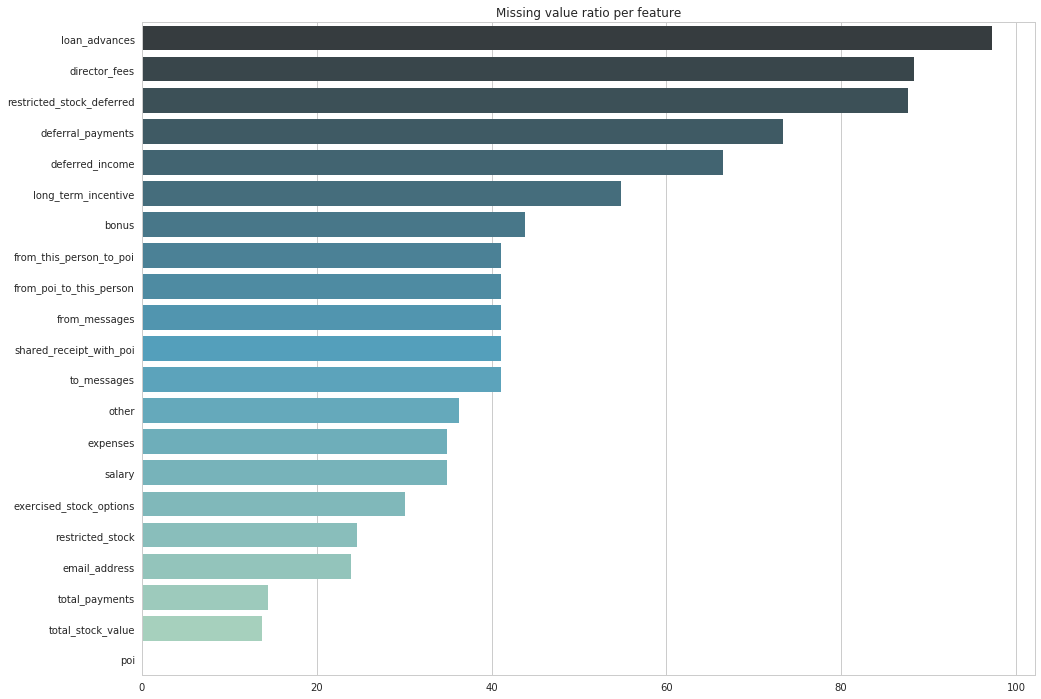

In [53]:
q1_missing_vals_plot(df_enron.T)

In [18]:
df_enron.plot.scatter(x='salary', y='bonus', color='steelblue');

In [19]:
# Remove any outliers before proceeding further
- tex: # This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()



SyntaxError: invalid syntax (<ipython-input-19-01f2897ad72e>, line 2)

# Feature engineering

In [ ]:
- Do correlation
- Feature Selection
- 

In [ ]:
features_list = ['poi','salary', 'bonus', 'total_stock_value', 'from_poi_to_this_person', 'from_this_person_to_poi'] 




maybe? = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']

# Classifiers

In [ ]:
To do:
- Feature importence
- Precision/recall
- 

In [ ]:
df_enron = df_enron.drop([''], axis=1)

In [ ]:
# Create the classifier

#clf = DecisionTreeClassifier()
clf = RFC(n_estimators=10)
#clf = SVC(C=500)
clf

In [ ]:
feature_list = []

In [ ]:
X = df_enron[feature_list].values
Y = df_enron['poi'].values

In [ ]:
(training_inputs, testing_inputs, training_scores, testing_scores) = train_test_split(X, Y, test_size=0.75, random_state=43)

In [ ]:
clf.fit(training_inputs, training_scores);

In [ ]:
clf.score(testing_inputs, testing_scores)

# Validation

In [ ]:
# Dump the classifier, dataset and features_list so anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

In [ ]:
#!jupyter nbconvert --to script FinalProject_TheEnronFraud.ipynb